In [16]:
import csv
import numpy as np
import os
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import ticker
from scipy.stats import spearmanr
import Plotting
import Dataloader
import datetime
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
import EarlyStopping

In [2]:
seed=999
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"
df=pd.read_csv(fname)

In [5]:
df["tau"]=df["Lr"]/(df["Lr"]+df["Lc"])
df["Xc"]=df["Lc"]/df["Nc"]

In [6]:
d=df[['Lc','Nc','Lr','Nr','lwc0','rm','nu_gam','tau','Xc']].to_numpy()
time=(df['time']).to_numpy()
input_num=d.shape[-1]

In [7]:
timestep,dataset=Dataloader.create_dataset_updatefunc(d, time)

In [8]:
means, sds, dataset=Dataloader.norm_data(dataset,1)
train_dataloader,val_dataloader,test_dataloader,train_dataset,val_dataset, test_dataset=Dataloader.dataset_transform(dataset)
    

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim


In [420]:
depth=input_num
class Network(nn.Module):

    def __init__(self,act):
        
        super().__init__()
       
        self.fc1 = nn.Linear(depth, 160)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        self.b1 = nn.BatchNorm1d(160)
        self.fc2 = nn.Linear(160, 120)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        self.b2 = nn.BatchNorm1d(120)
        self.fc3 = nn.Linear(120,60)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        self.b3 = nn.BatchNorm1d(60)
        
        self.fc4 = nn.Linear(60,60)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_out')
        self.fc5 = nn.Linear(60,30)
        nn.init.kaiming_normal_(self.fc5.weight, mode='fan_out')
        
        
        self.fc6 = nn.Linear(30,3)
        
        
        #self.dropout = nn.Dropout(0.25)
        self.activation = act
        
    def forward(self,x,verbose=False):
    
        x=self.activation((self.fc1(x)))
        #x = self.dropout(x)
        if verbose:
            print(x.shape)
        x=self.activation((self.fc2(x)))
        #x = self.dropout(x)
        if verbose:
            print(x.shape)
        x=self.activation((self.fc3(x)))
        #x = self.dropout(x)
        if verbose:
            print(x.shape)
        
        x=self.activation((self.fc4(x)))
        #x = self.dropout(x)
        if verbose:
            print(x.shape)
            
        x=self.activation((self.fc5(x)))
        #x = self.dropout(x)
        if verbose:
            print(x.shape)
  
        x=(self.fc6(x))
        if verbose:
            print(x.shape)
        
        return x

In [421]:
model = Network(nn.ReLU())
model.to(device)

Network(
  (fc1): Linear(in_features=9, out_features=160, bias=True)
  (b1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=160, out_features=120, bias=True)
  (b2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (b3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=60, out_features=60, bias=True)
  (fc5): Linear(in_features=60, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=3, bias=True)
  (activation): ReLU()
)

In [422]:
def loss_function(outputs,preds,j,mode="train"):
    criterion=nn.MSELoss()
    if mode=="train":
        writer.add_scalars("Training loss for moments", {'Lc':criterion(outputs[:,0],preds[:,0]),'Nc':criterion(outputs[:,1],preds[:,1]),'Nr':criterion(outputs[:,2],preds[:,2])}, j)
    #new_pred=torch.cat((pred[:,0:2],-pred[:,0].unsqueeze(1),pred[:,2:]),1)
    
    if mode=='val':
        writer.add_scalars("Validation loss for moments", {'Lc':criterion(outputs[:,0],preds[:,0]),'Nc':criterion(outputs[:,1],preds[:,1]),'Nr':criterion(outputs[:,2],preds[:,2])}, j)
    

    #new_outputs=torch.cat((outputs[:,0:2],delLr.unsqueeze(1),outputs[:,2:]),1)
    
    #delNc=(pred[0]*torch.from_numpy(sds[-3].reshape(1, -1)).to(device))+(torch.from_numpy(means[-3].reshape(1, -1)).to(device))
    #new_delNc=torch.exp(-delNc)
    mse_loss= criterion(outputs,preds)
    
    return mse_loss
#optimizer = torch.optim.SGD(model.parameters(), lr=(1e-3))
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [423]:
losses=[]
val_loss=[]
n_epochs=500
j=0
patience=20
log_dir = "runs/UFwith3/4moments/norp_relu_6L_earlystopping/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

early_stopping = EarlyStopping(patience=patience, verbose=True)
for epoch in range(n_epochs):  

    print(f'epoch {epoch}')
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        j+=1
        inputs=data[:,1:input_num+1].to(device)
        outputs=torch.cat((data[:,input_num+1:input_num+3],data[:,-1:]),1).to(device)
       
        
       
        optimizer.zero_grad()
        
        preds = model(inputs)
        loss = loss_function(outputs,preds,j)
        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        
        writer.add_scalar("Training Loss", loss.item() , j)
    print(f'Loss: {running_loss/ len(train_dataset)}')
    losses.append(running_loss / len(train_dataset))
    writer.add_scalar("Loss/train", losses[epoch], epoch)
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            
            inputs=data[:,1:input_num+1].to(device)
            outputs=torch.cat((data[:,input_num+1:input_num+3],data[:,-1:]),1).to(device)

            yhat = model(inputs)
            loss_v = loss_function(outputs,yhat,j,mode="val")
            running_loss += loss_v.item()* inputs.size(0)
    
    print(f'Loss: {(running_loss/len(val_dataset))}')
    val_loss.append(running_loss / len(val_dataset))
    writer.add_scalars("Training/Validation", {'Training':losses[epoch],'Validation':val_loss[epoch]}, epoch)
    early_stopping(val_loss[epoch], model)
    
    if early_stopping.early_stop:
            print("Early stopping")
            break
            
model.load_state_dict(torch.load('checkpoint.pt'))
   

epoch 0


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.4079931196805394


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2837388003267806
Validation loss decreased (inf --> 0.283739).  Saving model ...
epoch 1


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1951328893731139


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.24066432018387585
Validation loss decreased (0.283739 --> 0.240664).  Saving model ...
epoch 2


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.17535177284291295


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.22675671305125447
Validation loss decreased (0.240664 --> 0.226757).  Saving model ...
epoch 3


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16812059510415175


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.22173407558272104
Validation loss decreased (0.226757 --> 0.221734).  Saving model ...
epoch 4


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16412346777892187


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21904176204495107
Validation loss decreased (0.221734 --> 0.219042).  Saving model ...
epoch 5


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16213839144381392


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21531631477207228
Validation loss decreased (0.219042 --> 0.215316).  Saving model ...
epoch 6


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16036140695088877


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21551169490817365
EarlyStopping counter: 1 out of 20
epoch 7


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15960770250451534


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21254686929787098
Validation loss decreased (0.215316 --> 0.212547).  Saving model ...
epoch 8


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1582856476437056


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21339486842437322
EarlyStopping counter: 1 out of 20
epoch 9


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15746099325589927


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.211401164668222
Validation loss decreased (0.212547 --> 0.211401).  Saving model ...
epoch 10


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15718423646293297


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2108593338699149
Validation loss decreased (0.211401 --> 0.210859).  Saving model ...
epoch 11


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15618633492373624


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20982854608082635
Validation loss decreased (0.210859 --> 0.209829).  Saving model ...
epoch 12


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15629156342780992


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20986733182415465
EarlyStopping counter: 1 out of 20
epoch 13


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15548978642698383


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2112524621261139
EarlyStopping counter: 2 out of 20
epoch 14


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15601638936699175


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21344871334926388
EarlyStopping counter: 3 out of 20
epoch 15


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15528963640663054


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20786338530314658
Validation loss decreased (0.209829 --> 0.207863).  Saving model ...
epoch 16


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15506455549333104


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20837166128337223
EarlyStopping counter: 1 out of 20
epoch 17


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15478867058726167


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20927883600852504
EarlyStopping counter: 2 out of 20
epoch 18


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15469867423925082


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2112482417917602
EarlyStopping counter: 3 out of 20
epoch 19


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15380400578160958


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2148677809419769
EarlyStopping counter: 4 out of 20
epoch 20


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15446205260610368


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20889621703717998
EarlyStopping counter: 5 out of 20
epoch 21


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1545773255961479


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20735442734193918
Validation loss decreased (0.207863 --> 0.207354).  Saving model ...
epoch 22


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15409021478049328


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20840419471212593
EarlyStopping counter: 1 out of 20
epoch 23


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15402115594396248


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21216369797094958
EarlyStopping counter: 2 out of 20
epoch 24


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1540459911854893


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20768871669885441
EarlyStopping counter: 3 out of 20
epoch 25


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15408503037115814


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21424156117346158
EarlyStopping counter: 4 out of 20
epoch 26


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15352698594145267


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21273323107169767
EarlyStopping counter: 5 out of 20
epoch 27


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15385809056446556


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20725083658173943
Validation loss decreased (0.207354 --> 0.207251).  Saving model ...
epoch 28


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1537971289528039


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21032415463905943
EarlyStopping counter: 1 out of 20
epoch 29


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15320202381974105


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20908834010672347
EarlyStopping counter: 2 out of 20
epoch 30


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15336643364660343


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20926791932255062
EarlyStopping counter: 3 out of 20
epoch 31


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15319164906529414


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20807282691078594
EarlyStopping counter: 4 out of 20
epoch 32


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15309156479258867


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20770102688594996
EarlyStopping counter: 5 out of 20
epoch 33


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15349248254975362


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20777553315354252
EarlyStopping counter: 6 out of 20
epoch 34


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15280737465692973


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21316935507113466
EarlyStopping counter: 7 out of 20
epoch 35


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15289077378354127


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20831070848230004
EarlyStopping counter: 8 out of 20
epoch 36


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15245160133961455


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20861812472114605
EarlyStopping counter: 9 out of 20
epoch 37


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1533213176418439


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2127541654026468
EarlyStopping counter: 10 out of 20
epoch 38


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15261619560410303


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20869360766136535
EarlyStopping counter: 11 out of 20
epoch 39


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15270957124593773


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20697258568349802
Validation loss decreased (0.207251 --> 0.206973).  Saving model ...
epoch 40


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15203953368013987


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.21199035668677702
EarlyStopping counter: 1 out of 20
epoch 41


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15243068862117579


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20704683434397442
EarlyStopping counter: 2 out of 20
epoch 42


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15210092268488373


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20793899836274768
EarlyStopping counter: 3 out of 20
epoch 43


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15238605887454693


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20847456379713872
EarlyStopping counter: 4 out of 20
epoch 44


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.151824690883278


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20634868382744748
Validation loss decreased (0.206973 --> 0.206349).  Saving model ...
epoch 45


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15200192430112083


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20832037493845956
EarlyStopping counter: 1 out of 20
epoch 46


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15186655221638992


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20729121514961313
EarlyStopping counter: 2 out of 20
epoch 47


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1517918846817019


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20992849195091098
EarlyStopping counter: 3 out of 20
epoch 48


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15103084988764737


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2067585825707048
EarlyStopping counter: 4 out of 20
epoch 49


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15180137156394374


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20737305558350413
EarlyStopping counter: 5 out of 20
epoch 50


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.151066856492653


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20819923353911693
EarlyStopping counter: 6 out of 20
epoch 51


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15123158886977822


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2087692487955551
EarlyStopping counter: 7 out of 20
epoch 52


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15085237044383246


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2092481725811051
EarlyStopping counter: 8 out of 20
epoch 53


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15063375355904718


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20728620010152377
EarlyStopping counter: 9 out of 20
epoch 54


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15117539095977112


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20756597300498106
EarlyStopping counter: 10 out of 20
epoch 55


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15042020285699587


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20629651962018167
Validation loss decreased (0.206349 --> 0.206297).  Saving model ...
epoch 56


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1506939503852314


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20537927309177537
Validation loss decreased (0.206297 --> 0.205379).  Saving model ...
epoch 57


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1499045563383259


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20654743263720993
EarlyStopping counter: 1 out of 20
epoch 58


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1505352949407725


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2068006439583649
EarlyStopping counter: 2 out of 20
epoch 59


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15016261307929452


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20731454511697883
EarlyStopping counter: 3 out of 20
epoch 60


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14957743797351067


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2058594284978023
EarlyStopping counter: 4 out of 20
epoch 61


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1495063120878406


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2072502999552871
EarlyStopping counter: 5 out of 20
epoch 62


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1497210247278276


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20585583213652878
EarlyStopping counter: 6 out of 20
epoch 63


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14906937895492306


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20571890915458882
EarlyStopping counter: 7 out of 20
epoch 64


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1495550941589661


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20705765376315424
EarlyStopping counter: 8 out of 20
epoch 65


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1491748870497348


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20660090028091516
EarlyStopping counter: 9 out of 20
epoch 66


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.149255003825534


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20720576375768257
EarlyStopping counter: 10 out of 20
epoch 67


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14891857136849537


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20899049472373254
EarlyStopping counter: 11 out of 20
epoch 68


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14909697555756976


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20505150742870767
Validation loss decreased (0.205379 --> 0.205052).  Saving model ...
epoch 69


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14782963214896894


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20762970970082095
EarlyStopping counter: 1 out of 20
epoch 70


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14801644801024996


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20847231822538764
EarlyStopping counter: 2 out of 20
epoch 71


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14783265501577533


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2069590539503612
EarlyStopping counter: 3 out of 20
epoch 72


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14806567339149432


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2078892917015034
EarlyStopping counter: 4 out of 20
epoch 73


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14744770187023434


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20422753817258493
Validation loss decreased (0.205052 --> 0.204228).  Saving model ...
epoch 74


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14782650073200343


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.2051658298523112
EarlyStopping counter: 1 out of 20
epoch 75


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14703179184246232


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20444933159232825
EarlyStopping counter: 2 out of 20
epoch 76


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1470962696789246


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20475851567013903
EarlyStopping counter: 3 out of 20
epoch 77


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14657299813515445


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20471825786213577
EarlyStopping counter: 4 out of 20
epoch 78


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.14734530996664583


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.20595844097027607
EarlyStopping counter: 5 out of 20
epoch 79


  0%|          | 0/1181 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,}, "UFNet_3m_4m_relu.pt")

In [44]:
model = Network(act=nn.Tanh())
model.to(device)

Network(
  (fc1): Linear(in_features=9, out_features=160, bias=True)
  (b1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=160, out_features=120, bias=True)
  (b2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (b3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=60, out_features=60, bias=True)
  (fc5): Linear(in_features=60, out_features=30, bias=True)
  (fc6): Linear(in_features=30, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (activation): Tanh()
)

In [937]:
#model =  torch.load("UFNet_3m.pt")
checkpoint = torch.load("UFNet_3m.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']



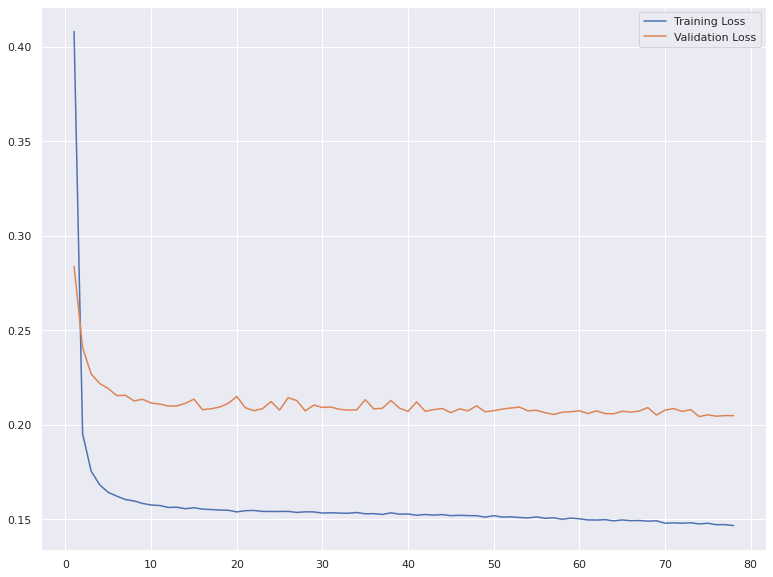

In [424]:
Plotting.plot_train(losses,val_loss,start=0,last=-1)

In [425]:
with torch.no_grad():
    d = test_dataset[:]

    inputs =d[:,1:input_num+1].to(device)
    targets = d[:,input_num+1:]
    model.eval()
    updates = model(inputs)
    

    inputs,updates, targets,time = inputs.to('cpu').numpy(), updates.to('cpu').numpy(), targets.to('cpu').numpy(),d[:,0].to('cpu').numpy()
    
    
    
    
updates=np.concatenate((updates[:,0:2],-updates[:,0].reshape(-1,1),updates[:,2].reshape(-1,1)),1)

#inputs = d[:,1:input_num.to('cpu').numpy()
inputs_orig= inputs* sds[0:input_num].reshape(1, -1) + means[:input_num].reshape(1, -1)
updates_orig= updates * sds[input_num:].reshape(1, -1) + means[input_num:].reshape(1, -1)

predictions_=[]
targets_=[]
timestep=[]
for i in range(len(d[:,0])-1):

    if d[i,0]<d[i+1,0]:
        timestep.append(d[i,0])
        predictions_.append((inputs_orig[i,0:4]+(updates_orig[i,:]*20)))
        
        targets_.append(inputs_orig[i+1,0:4])


In [35]:
def plot_predictions(targets,predictions,x,y,var,main_title,tick=4,fig_size=[13,10]):
    sns.set_theme(style="darkgrid")
    n=targets.shape[-1]
    fig= plt.figure()
    fig.set_size_inches(fig_size)
    color=iter(cm.rainbow(np.linspace(0,1,n)))
    for i in range(n):
        ax = fig.add_subplot(x,y, i + 1)
        c=next(color)
        sns.regplot(x=targets[:,i],y=predictions[:,i],color=c,label=var[i])
        
        corr, _ = spearmanr(predictions[:,i], targets[:,i])
        plt.xlabel('Targets')    
        plt.ylabel('Predictions_nn')
        plt.legend()
        plt.title(f" R: {corr}")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(tick))   
    fig.suptitle(main_title, fontsize="x-large")


In [39]:
act=nn.ReLU()
checkpoint=326

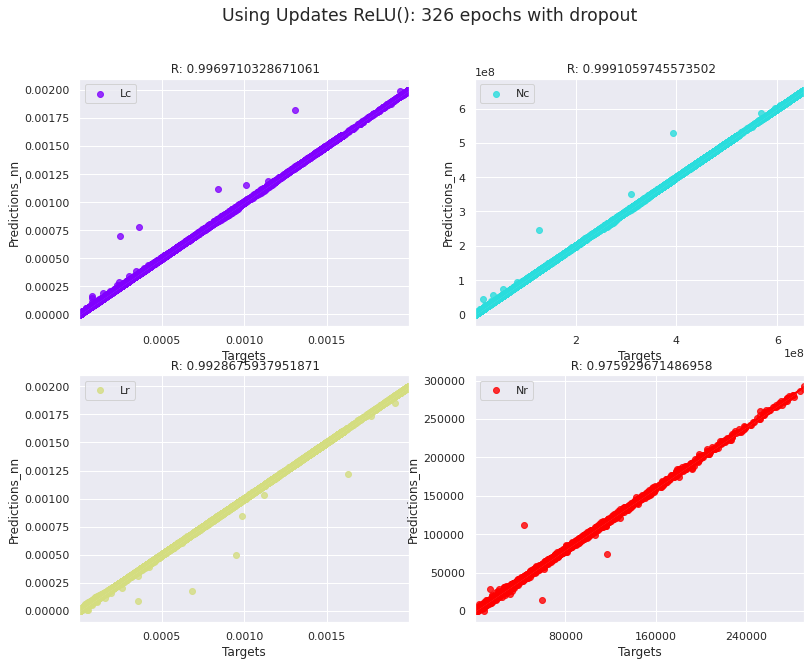

In [426]:
plot_predictions(np.asarray(targets_),np.asarray(predictions_),2,2,['Lc','Nc','Lr','Nr'],f"Using Updates {act}: {checkpoint} epochs with dropout")

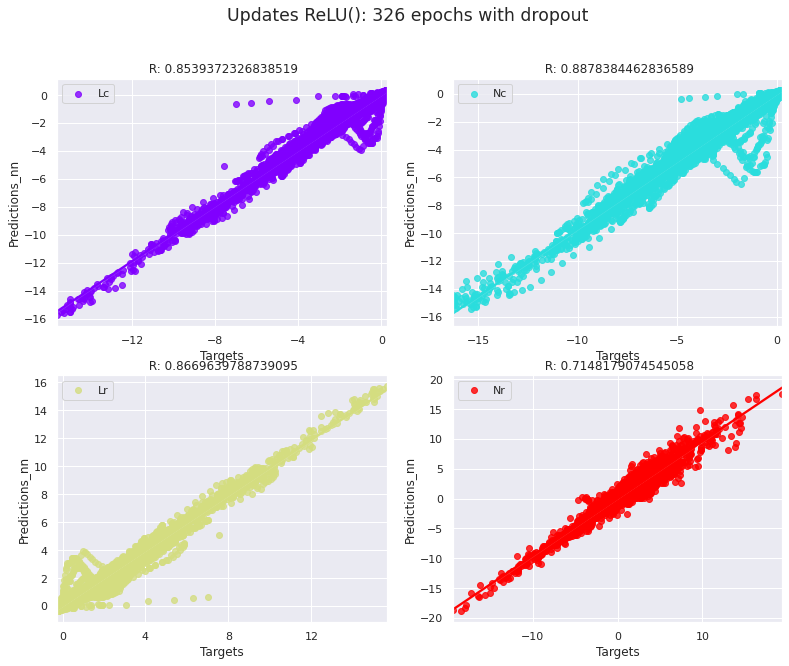

In [436]:
plot_predictions(np.asarray(targets),np.asarray(updates),2,2,['Lc','Nc','Lr','Nr'],f"Updates {act}: {checkpoint} epochs with dropout")

In [64]:
time=d[:,0]
sim_info=[]
initial_loc=0



for t in range (0,len(time)-1):
    if time[t+1]<time[t]:
        end_loc=t
        sim_duration=time[end_loc]-time[initial_loc]
        sim_info.append(np.array([initial_loc,end_loc,sim_duration.to('cpu').numpy()]))
        initial_loc= t+1
      

In [988]:
def moment_calc(preds,inputs_,Lr_input,target_,Lr_target):
    
    preds=(torch.cat((preds[:,0:2],-preds[:,0].reshape(-1,1),preds[:,2].reshape(-1,1)),1)).to('cpu').numpy()#Normalized
    
    update_orig_= remove_norm(preds,input_num)#Un-normalize
    update_orig_=update_orig_.reshape(-1,)
  
    update_orig_=((np.min(update_orig_[0],0)),(np.min(update_orig_[1],0)),(np.max(-update_orig_[0],0)),(update_orig_[-1]))
    update_orig_=np.asarray(update_orig_).reshape(1,-1)
    #Taking care of inputs
    
    print(update_orig_[:,1])
    inputs_=(torch.cat((inputs_[0:2].reshape(1,-1),Lr_input.reshape(1,-1),inputs_[-1].reshape(1,-1)),1)).to('cpu').numpy()
    inputs_orig_= remove_norm(inputs_,0,4)
    
    #print(inputs_orig_)
    predictions_orig_=inputs_orig_+(update_orig_)*20#Not normalized
    
    #Taking care of targets
    target_=(torch.cat((target_[0:2].reshape(1,-1),Lr_target.reshape(1,-1),target_[2].reshape(1,-1)),1)).to('cpu').numpy()
    target_orig_=remove_norm(target_,0,4)#Returns un-normalized value of targets
    
    new_input,Lr_new=create_input(predictions_orig_)
    
    return new_input,Lr_new,predictions_orig_,target_orig_


In [990]:
def create_input(predictions_orig_):
  
    tau=predictions_orig_[:,2]/model_params[0]
    xc=predictions_orig_[:,0]/predictions_orig_[:,1]
   
    new_input_=np.concatenate((predictions_orig_[:,0:],model_params.reshape(1,-1),tau.reshape(1,-1),xc.reshape(1,-1)),axis=1)
    
    norm_input_=new_input_ - means[:input_num] / sds[:input_num]
    
    #norm_input_=predictions_orig_ - means[:4] / sds[:4]#normalized here
    
    #new_input_=np.concatenate((norm_input_,model_params.reshape(1,-1)),axis=1)
    
    norm_input= np.concatenate((norm_input_[:,0:2],norm_input_[:,3:input_num+1]),1)
    return norm_input,norm_input_[:,2]

In [362]:
def remove_norm(arr,start=0,last=None):
    norm_arr= (arr * sds[start:last].reshape(1, -1)) + means[start:last].reshape(1, -1)
    return norm_arr
    

In [494]:
class simulation_forecast:
     def __init__(self, start_point,end_point):
        self.start_point=start_point
        self.end_point=end_point
        self.inputs=(d[start_point:end_point,1:input_num+1]).to(device)
        self.model_params=d[self.start_point,5:8].to('cpu').numpy()*sds[4:7].reshape(1, -1) + means[4:7].reshape(1, -1)
        self.targets_orig=d[self.start_point+1:self.end_point+1,1:5]
        self.predictions_orig=[]
        self.new_input=None
        self.preds=None

     def test(self):
        with torch.no_grad():
            model.eval()
            self.new_input=self.inputs[0,:]
          
            self.preds=model(self.new_input.reshape(1,-1))
            print(f"Input Before:{self.new_input}")
            self.moment_calc()
            
            for i in range (self.start_point+1,self.end_point):
                model.eval()
                self.new_input=self.new_input.astype(np.float32)
                self.new_input=(torch.from_numpy(self.new_input)).to(device)
                self.preds=model(self.new_input)
                self.new_input=self.new_input.reshape(input_num)
                self.moment_calc()
               
             
                
     def moment_calc(self):
        #self.new_input=(torch.from_numpy(self.new_input.reshape(input_num))[:]).to(device)
        self.update_calc()
        print(f"Input Before:{self.new_input}")
        self.input_calc()
        print(f"Input:{self.new_input}")
        print(f"Updates:{self.preds*20}")
        predictions_orig_=self.new_input+(self.preds*20.0)
        
        self.predictions_orig.append(predictions_orig_)
        print(f"Predictions:{predictions_orig_}")
        self.create_input(predictions_orig_)
        
        
                
     def update_calc(self):
        self.preds=(torch.cat((self.preds[:,0:2],-self.preds[:,0].reshape(-1,1),self.preds[:,2].reshape(-1,1)),1)).to('cpu').numpy()#Normalized
        
        
        self.preds_= remove_norm(self.preds,input_num)#Un-normalize
        self.preds=self.preds.reshape(-1,)
        print(f"Updates before correction:{self.preds}")
        self.preds=((min(self.preds[0],0)),(min(self.preds[1],0)),(max(-self.preds[0],0)),(self.preds[2]))
        #self.preds=(self.preds[0],0),(self.preds[1]),(-self.preds[0]),(self.preds[2]))
  
        self.preds=np.asarray(self.preds).reshape(1,-1)
     
        
     def input_calc(self):
        
        self.new_input=(self.new_input[0:4]).to('cpu').numpy()
        print(f"Input After:{self.new_input}")
        self.new_input= remove_norm(self.new_input,0,4)
        
   
     def create_input(self,predictions_orig_):
  
        tau=predictions_orig_[0,2]/predictions_orig_[0,2]+predictions_orig_[0,0]#self.model_params[:,0]
        xc=predictions_orig_[0,0]/predictions_orig_[0,1]
        
        
        new_input_=np.concatenate((predictions_orig_[:,0:],self.model_params.reshape(1,-1),tau.reshape(1,-1),xc.reshape(1,-1)),axis=1)
        print(f"New Input(not normalized):{new_input_}")
        self.new_input=(new_input_ - means[:input_num].reshape(1, -1)) / sds[:input_num].reshape(1, -1)
         
        #self.new_input=(torch.from_numpy(self.new_input.reshape(input_num))[:]).to(device)
       

       



In [ ]:
d = test_dataset[:]
new_forecast=simulation_forecast(int(sim_info[2][0])+130,int(sim_info[2][1]))
new_forecast.test()

In [497]:
predictions_orig=np.asarray(new_forecast.predictions_orig).reshape(-1,4)
targets_orig=remove_norm(new_forecast.targets_orig.to('cpu').numpy(),0,4)

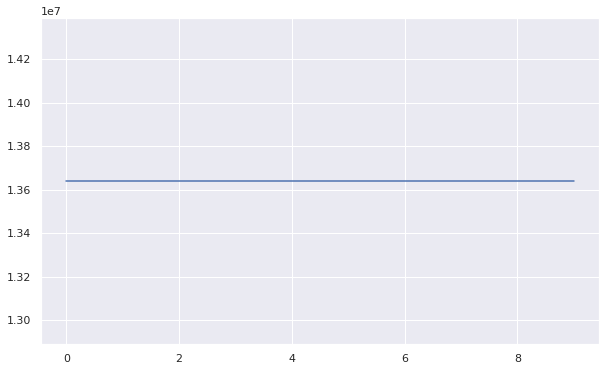

In [519]:
var=1
mom="Nr"
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
time= [x for x in range(0, len(predictions_orig))]

plt.plot(time[:10],predictions_orig[:10,var])
#plt.plot(time[:300],targets_orig[:300,var])

In [ ]:
def simulation_forecast(n=2):
    
    with torch.no_grad():
        d = test_dataset[:]

        inputs = torch.cat((d[:,1:3],d[:,4:input_num+1]),1).to(device)
        Lr=d[:,3]
        targets_orig=[]
        time=d[:,0]

        prediction_orig=[]
        flag=0
        model_params=inputs[int(sim_info[n][0]),3:6].to('cpu').numpy()*sds[4:7].reshape(1, -1) + means[4:7].reshape(1, -1)
        
        for i in range (int(sim_info[n][0]),int(sim_info[n][1])):
            print(time[i])

            if flag==0:
                model.eval()
                preds=model(inputs[i,:].reshape(1,-1))
                new_input,Lr_new,predictions_orig_,target_orig_=moment_calc(preds,inputs[i,0:3],Lr[i],inputs[i+1,0:3],Lr[i+1])


                print(target_orig_)
                print(predictions_orig_)
                prediction_orig.append(predictions_orig_)

                targets_orig.append(target_orig_)
                flag+=1
                #print(new_input)
            else:

                model.eval()
                new_input=new_input.astype(np.float32)
                preds=model((torch.from_numpy(new_input)).to(device))

                new_input,Lr_new,predictions_orig_,target_orig_=moment_calc(preds,torch.from_numpy(new_input.reshape(input_num-1))[0:3].to(device),torch.from_numpy(Lr_new).to(device),inputs[i+1,0:3],Lr[i+1])


                print(target_orig_)
                print(predictions_orig_)
                prediction_orig.append(predictions_orig_)

                targets_orig.append(target_orig_)


        return prediction_orig,targets_orig

## Problematic Cases

In [185]:
np.where(np.asarray(updates)[:,0]>3)

(array([ 6848,  6849,  6850,  6851,  6852,  6853,  6854,  6855,  6856,
         6857,  6858,  6859,  6860,  6861,  6862,  6863,  6864,  6865,
         6866,  6867,  6868,  6869,  6870,  6871,  6872,  6873,  6874,
         6875,  6876,  6877,  6878,  6879,  6880,  6881,  6882,  6883,
         6884,  6885,  6886,  6887,  6888,  6889,  6890,  6891,  6892,
         6893,  6894,  6895,  6896,  6897,  6898,  6899,  6900,  6901,
         6902,  6903,  6904,  6905,  6906,  6907,  6908,  6909,  6910,
        51895, 51896, 51897, 51898, 51899, 51900, 51901, 51902, 51903,
        51904, 51905, 51906, 51907, 51908, 51909, 51910, 51911, 51912,
        51913, 51914, 51915, 51916, 51917, 51918, 51919, 51920, 51921,
        51922, 51923, 51924, 51925, 51926, 51927]),)

In [319]:
np.where(np.asarray(updates)[:,0]<-20)

(array([], dtype=int64),)

In [320]:
np.where(np.asarray(targets)[:,0]<-15)

(array([ 7949, 20221, 20222, 25069, 25070, 63046, 84738, 84739, 84740]),)

In [238]:
np.where(np.asarray(targets)[:,1]<-15)

(array([35237, 35238, 35239, 35240, 35241, 35242, 35243, 35244, 35245,
        35246, 35247, 35255, 35256, 35257, 35258, 35259, 35260, 35261,
        35262, 35263, 35264]),)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

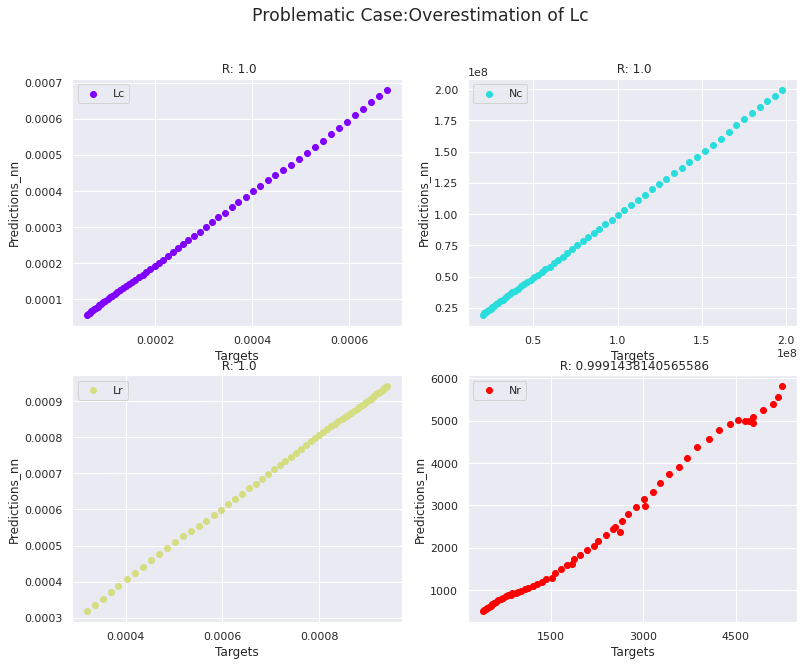

In [316]:
Plotting.plot_predictions(np.asarray(targets_)[6848:6910,:],np.asarray(predictions_)[6848:6910,:],2,2,['Lc','Nc','Lr','Nr'],'Problematic Case:Overestimation of Lc ')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

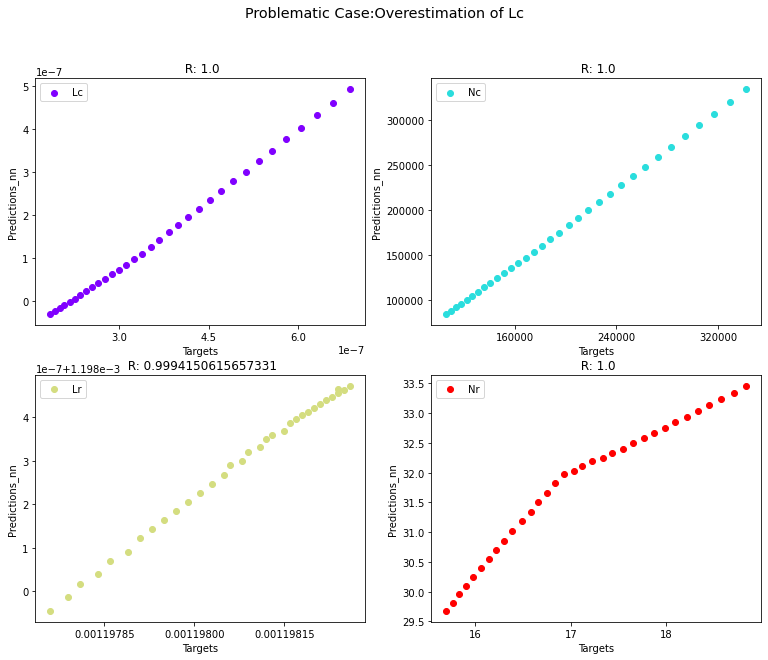

In [189]:
st=51895
last=51927


Plotting.plot_predictions(np.asarray(targets_)[st:last+1,:],np.asarray(predictions_)[st:last+1,:],2,2,['Lc','Nc','Lr','Nr'],'Problematic Case:Overestimation of Lc ')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

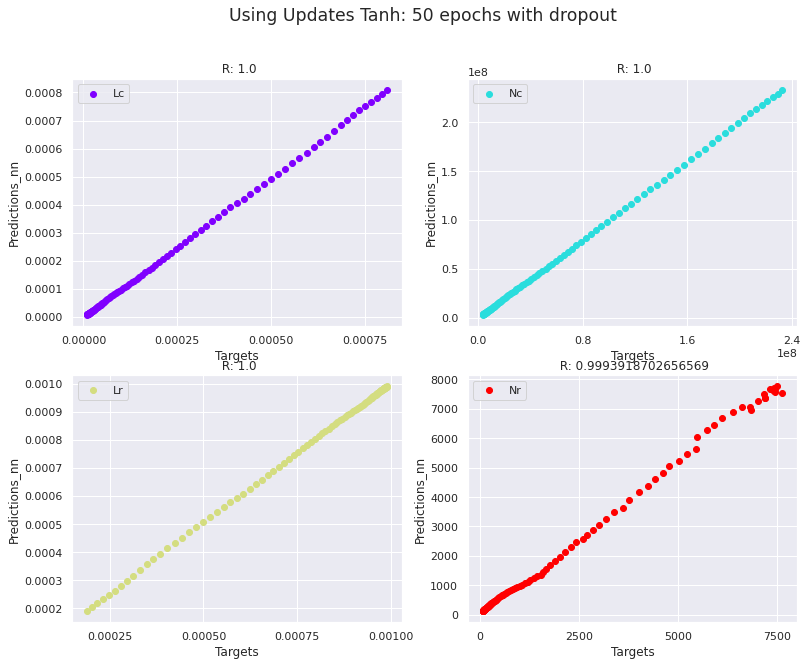

In [317]:
Plotting.plot_predictions(np.asarray(targets_)[11016:11075+45,:],np.asarray(predictions_)[11016:11075+45,:],2,2,['Lc','Nc','Lr','Nr'],'Using Updates Tanh: 50 epochs with dropout')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

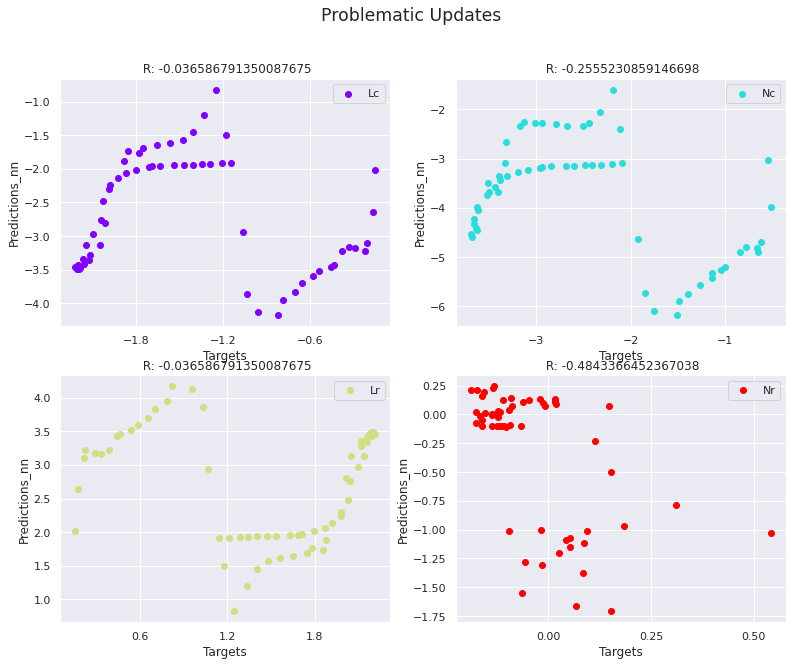

In [318]:
Plotting.plot_predictions(np.asarray(targets)[11016:11075,:],np.asarray(updates)[11016:11075,:],2,2,['Lc','Nc','Lr','Nr'],'Problematic Updates')

Text(0.5, 1.0, 'Lc vs Time')

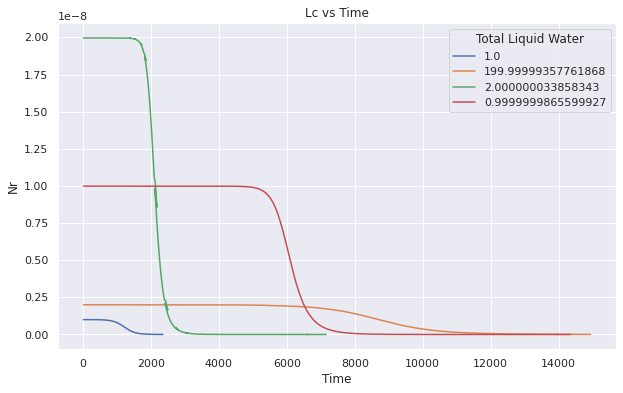

In [305]:
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["time"][0:118]),(df["Lc"].iloc[0:118])/1000000,label=df['lwc0'].iloc[1]*1000)
plt.plot((time[1087:1834]),(inputs_orig[1087:1834,0])/100000,label=inputs_orig[1086,4]*1e6)
plt.plot((time[35237-99:35264+298]),(inputs_orig[35237-99:35264+298,0])/100000,label=inputs_orig[35237-99,4]*1000)
plt.plot((time[11202-280:11639]),(inputs_orig[11202-280:11639,0])/100000,label=inputs_orig[11202-280,4]*1000)
plt.xlabel('Time')
plt.ylabel('Nr')
plt.legend(title="Total Liquid Water")
plt.title("Lc vs Time")

Text(0.5, 1.0, 'Lc vs Tau')

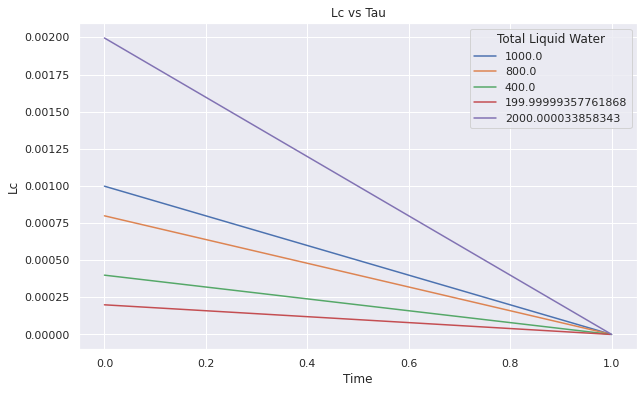

In [317]:
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"][0:118]),(df["Lc"].iloc[0:118]),label=df['lwc0'].iloc[1]*1e6)

plt.plot((df["tau"].iloc[119:304]),(df["Lc"].iloc[119:304]),label=df['lwc0'].iloc[119]*1e6)
plt.plot((df["tau"].iloc[454:977]),(df["Lc"].iloc[454:977]),label=df['lwc0'].iloc[454]*1e6)
plt.plot((inputs_orig[1087:1834,-2]),(inputs_orig[1087:1834,0]),label=inputs_orig[1086,4]*1e6)

#plt.plot((inputs_orig[11202-280:11639,-2]),(inputs_orig[11202-280:11639,0]),label=inputs_orig[11202-280,4]*1e6)
plt.plot((inputs_orig[35237-99:35264+298,-2]),(inputs_orig[35237-99:35264+298,0]),label=inputs_orig[35237-99,4]*1e6)
plt.xlabel('Time')
plt.ylabel('Lc')
plt.legend(title="Total Liquid Water")
plt.title("Lc vs Tau")

Text(0.5, 1.0, 'Nc vs Tau')

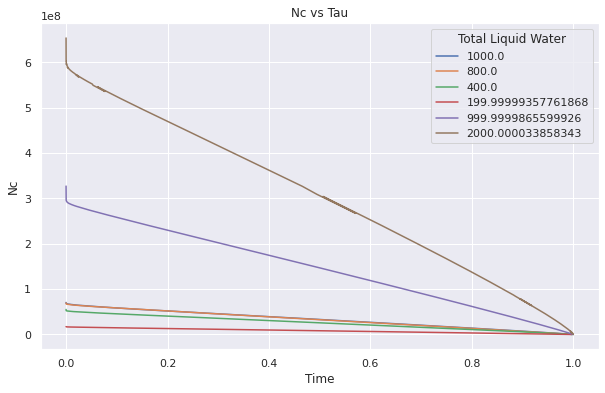

In [320]:
var=1
mom="Nc"
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"][0:118]),(df[mom].iloc[0:118]),label=df['lwc0'].iloc[1]*1e6)

plt.plot((df["tau"].iloc[119:304]),(df[mom].iloc[119:304]),label=df['lwc0'].iloc[119]*1e6)
plt.plot((df["tau"].iloc[454:977]),(df[mom].iloc[454:977]),label=df['lwc0'].iloc[454]*1e6)
plt.plot((inputs_orig[1087:1834,-2]),(inputs_orig[1087:1834,var]),label=inputs_orig[1086,4]*1e6)

plt.plot((inputs_orig[11202-280:11639,-2]),(inputs_orig[11202-280:11639,var]),label=inputs_orig[11202-280,4]*1e6)
plt.plot((inputs_orig[35237-99:35264+298,-2]),(inputs_orig[35237-99:35264+298,var]),label=inputs_orig[35237-99,4]*1e6)
plt.xlabel('Time')
plt.ylabel(mom)
plt.legend(title="Total Liquid Water")
plt.title(f"{mom} vs Tau")

In [329]:
np.asarray(targets_)

array([[1.99725001e-04, 3.42946999e+07, 1.89141903e-10, 4.33691979e-01],
       [1.99725001e-04, 3.42937997e+07, 1.89141903e-10, 4.34304817e-01],
       [1.99725001e-04, 3.42854000e+07, 1.89141903e-10, 4.36143329e-01],
       ...,
       [5.66812564e-07, 1.04655285e+05, 3.98900998e-04, 3.62037934e+01],
       [5.54217648e-07, 1.02506505e+05, 3.98913000e-04, 3.56013741e+01],
       [5.41938734e-07, 1.00397469e+05, 3.98925002e-04, 3.49805697e+01]])

Text(0.5, 1.0, 'Nr vs Tau')

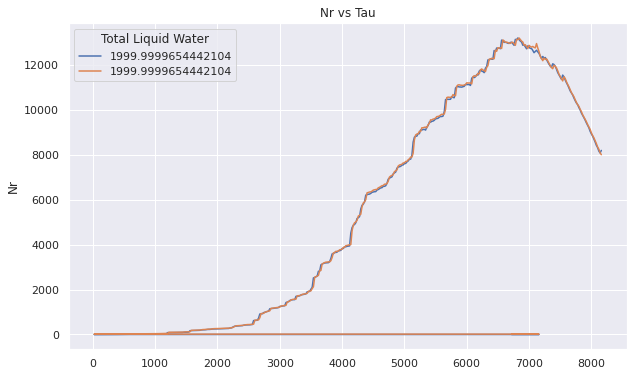

In [321]:
var=3
mom="Nr"
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)

#plt.plot(inputs_orig[35237-99:35264+298,-2],(inputs_orig[35237-99:35264+298,var]),label=inputs_orig[35237-99,4]*1e6)

plt.plot(time[35237-99:35264+298],(np.asarray(targets_)[35237-99:35264+298,var]),label=inputs_orig[35237-99,4]*1e6)

plt.plot(time[35237-99:35264+298],(np.asarray(predictions_)[35237-99:35264+298,var]),label=inputs_orig[35237-99,4]*1e6)



plt.ylabel(mom)
plt.legend(title="Total Liquid Water")
plt.title(f"{mom} vs Tau")

In [336]:
np.asarray(targets_)[35237-99:35264+298,var]

array([ 8.68528998e+03,  9.67271006e+03,  1.04581000e+04,  1.13900000e+04,
        8.33506006e+03,  9.22369993e+03,  9.82193998e+03,  1.32062002e+04,
        1.45736000e+04,  1.49771002e+04,  1.53707001e+04,  1.55229001e+04,
        1.64209001e+04,  1.62835001e+04,  1.69845005e+04,  1.66452998e+04,
        1.56382000e+04,  1.47565002e+04,  1.44495997e+04,  1.43057000e+04,
        1.36412002e+04,  1.11436001e+04,  1.04210999e+04,  9.50062007e+03,
        1.15567001e+04,  1.03756001e+04,  9.64583008e+03,  8.59813008e+03,
        7.63491999e+03,  6.79317000e+03,  6.02255002e+03,  5.32464994e+03,
        4.69747001e+03,  4.14486000e+03,  3.65887003e+03,  3.22095992e+03,
        2.92062999e+03,  2.57767998e+03,  2.12170985e+03,  1.86905011e+03,
        1.63954000e+03,  1.45641986e+03,  1.97003011e+03,  1.73442012e+03,
        1.53185005e+03,  1.35227976e+03,  1.19124015e+03,  1.04821000e+03,
        9.22903107e+02,  8.15893093e+02,  7.25760012e+02,  6.44472015e+02,
        5.71777226e+02,  

Text(0.5, 1.0, 'Nr vs Tau')

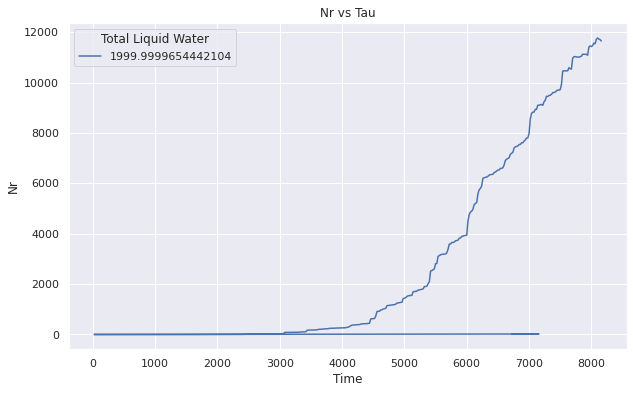

In [322]:
var=3
mom="Nr"
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)

plt.plot((time[35237-99:35264+298]),(inputs_orig[35237-99:35264+298,var]),label=inputs_orig[35237-99,4]*1e6)
plt.xlabel('Time')
plt.ylabel(mom)
plt.legend(title="Total Liquid Water")
plt.title(f"{mom} vs Tau")

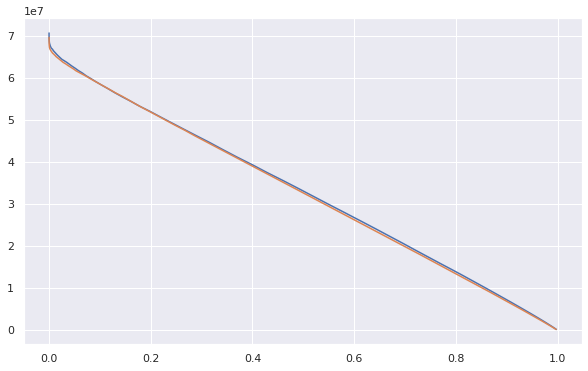

In [322]:
var=1
mom="Nc"
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"][0:118]),(df[mom].iloc[0:118]),label=df['lwc0'].iloc[1]*1e6)
plt.plot((df["tau"].iloc[119:304]),(df[mom].iloc[119:304]),label=df['lwc0'].iloc[119]*1e6)

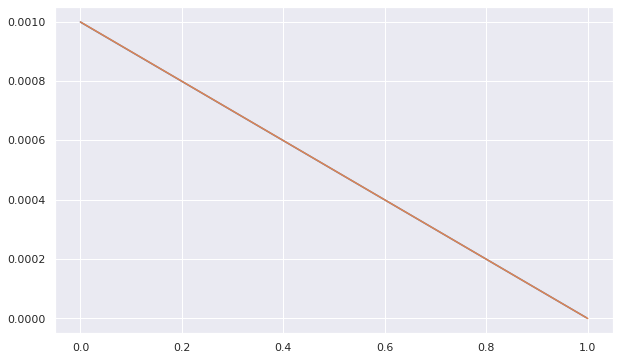

In [318]:
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"][0:118]),(df["Lc"].iloc[0:118]),label=df['lwc0'].iloc[1]*1e6)


In [269]:
time[35190]

1040.0

In [279]:
df[['time','lwc0','nu_gam']].iloc[t]

time      10460.0000
lwc0          0.0004
nu_gam        2.5000
Name: 487879, dtype: float64

In [276]:
int(len(df['time'])*0.8)

390304

In [291]:
df[['Lc','Nc','Lr','Nr']].iloc[t]==df[['Lc','Nc','Lr','Nr']].iloc[t+1]

Lc    False
Nc    False
Lr    False
Nr    False
dtype: bool

In [290]:
df[['Lc','Nc','Lr','Nr']].iloc[t+1]

Lc    5.300620e-07
Nc    9.835570e+04
Lr    3.989370e-04
Nr    3.439390e+01
Name: 487880, dtype: float64

In [ ]:
num=0
for t in range(0,len(df['time'])-1):
    if df['time'].iloc[t]==df['time'].iloc[t+1]:
        num+=1
        print(f"Timestep number:{t}")
        print(f"Timestamp:{df['time'].iloc[t]}")
        #print(df[['lwc0','rm','nu_gam']].iloc[t])
        print(df[['Lc','Nc','Lr','Nr']].iloc[t]==df[['Lc','Nc','Lr','Nr']].iloc[t+1])

In [286]:
n=0
for t in range(0,len(time)-1):
    if time[t]==time[t+1]:
        n+=1
        print(f"Timestep number:{t}")
        print(f"Timestamp:{time[t]}")
        print(inputs_orig[t,4:7])

1580

In [231]:
for t in range (1086+1,len(time)):
    if time[t]>time[t+1]:
        end_sim=t
        break

In [232]:
end_sim

1834

Text(0.5, 1.0, 'Nr vs Time')

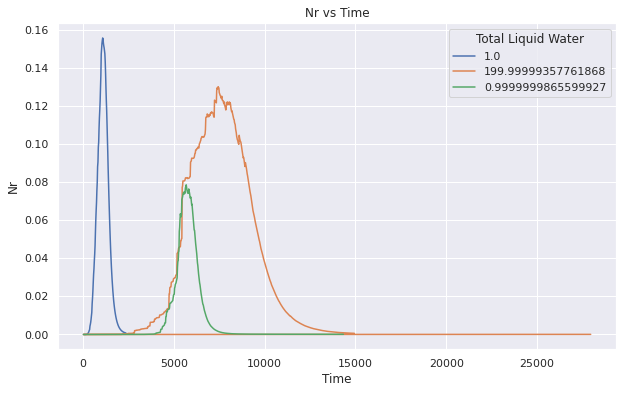

In [234]:
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["time"][0:118]),(df["Nr"].iloc[0:118])/1000000,label=df['lwc0'].iloc[1]*1000)
plt.plot((time[1086:1834]),(inputs_orig[1086:1834,3])/100000,label=inputs_orig[1086,4]*1e6)
plt.plot((time[11202-280:11639]),(inputs_orig[11202-280:11639,3])/100000,label=inputs_orig[11202-280,4]*1000)
plt.xlabel('Time')
plt.ylabel('Nr')
plt.legend(title="Total Liquid Water")
plt.title("Nr vs Time")

Text(0.5, 1.0, 'Nr vs Time')

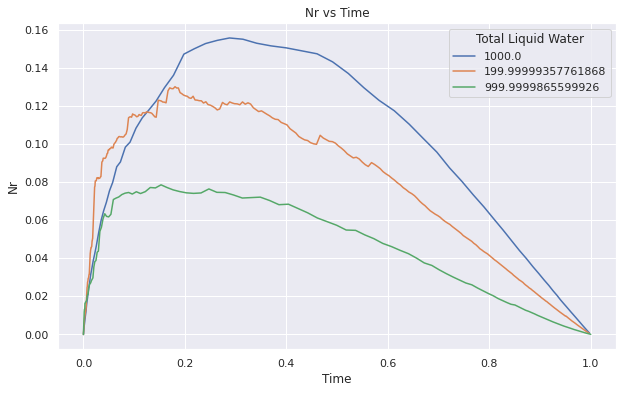

In [235]:
fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"][0:118]),(df["Nr"].iloc[0:118])/1000000,label=df['lwc0'].iloc[1]*1e6)
plt.plot((inputs_orig[1087:1834,-2]),(inputs_orig[1087:1834,3])/100000,label=inputs_orig[1086,4]*1e6)

plt.plot((inputs_orig[11202-280:11639,-2]),(inputs_orig[11202-280:11639,3])/100000,label=inputs_orig[11202-280,4]*1e6)
plt.xlabel('Time')
plt.ylabel('Nr')
plt.legend(title="Total Liquid Water")
plt.title("Nr vs Time")

In [ ]:
inputs_orig[11202,4]

In [204]:
np.where(np.asarray(updates)[:,1]<-30)

(array([11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210,
        11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219,
        11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228,
        11229, 11230, 11231, 11232, 11233]),)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

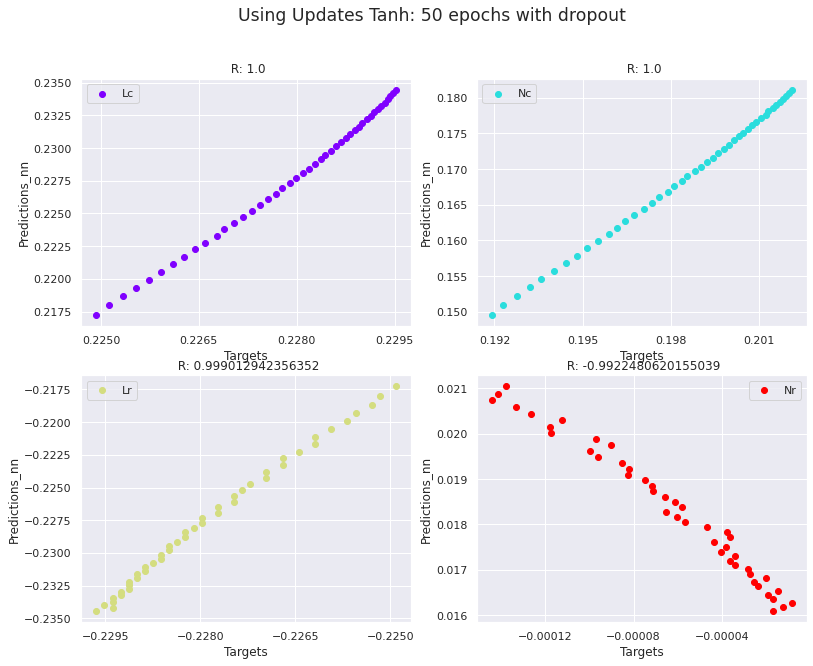

In [323]:
Plotting.plot_predictions(np.asarray(targets)[11193:11237,:],np.asarray(updates)[11193:11237,:],2,2,['Lc','Nc','Lr','Nr'],'Using Updates Tanh: 50 epochs with dropout')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

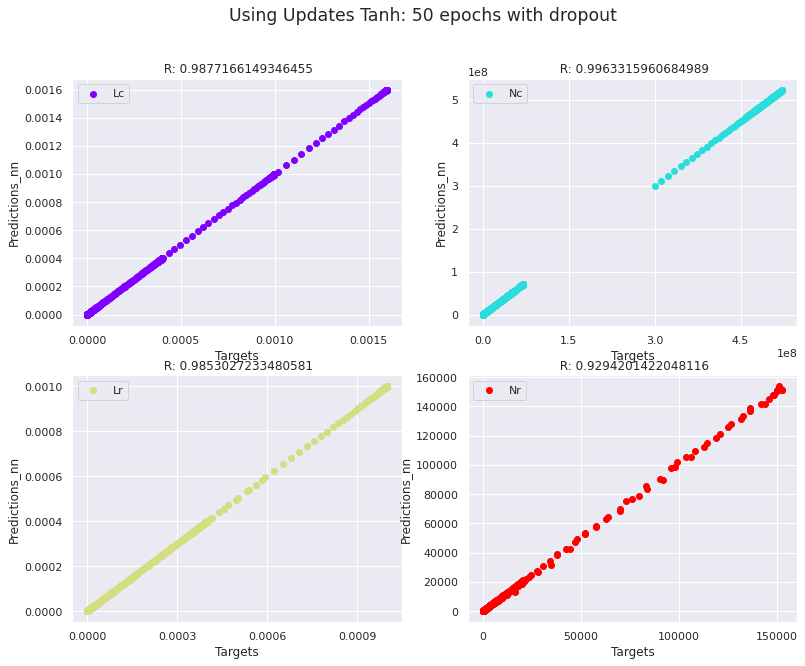

In [324]:
Plotting.plot_predictions(np.asarray(targets_)[11193:12237,:],np.asarray(predictions_)[11193:12237,:],2,2,['Lc','Nc','Lr','Nr'],'Using Updates Tanh: 50 epochs with dropout')

## Analyzing the viability of tau


In [6]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"
df=pd.read_csv(fname)
df["tau"]=df["Lr"]/(df["Lr"]+df["Lc"])
df["Xc"]=df["Lc"]/df["Nc"]

In [15]:
sns.set(style="darkgrid")

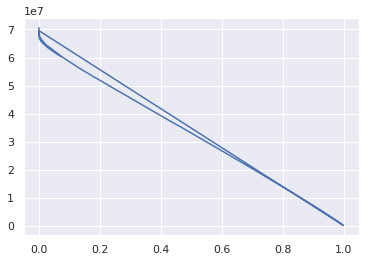

In [17]:
plt.plot(df["tau"].iloc[0:200],df["Nc"].iloc[0:200])

In [125]:
for t in range (454,len(df['time'])):
    if df['time'].iloc[t]>df['time'].iloc[t+1]:
        end_sim=t
        break

In [126]:
end_sim

977

In [104]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam,tau,Xc
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0,6.952180e-12,1.413810e-11
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0,1.667227e-07,1.416526e-11
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0,1.987517e-07,1.419075e-11
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0,2.411406e-07,1.421419e-11
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0,2.919390e-07,1.424357e-11


In [127]:
df[['lwc0','nu_gam']].iloc[454]

lwc0      0.0004
nu_gam    1.5000
Name: 454, dtype: float64

In [107]:
df['lwc0'].iloc[1]

0.001

Text(0.5, 1.0, 'Nr vs Time')

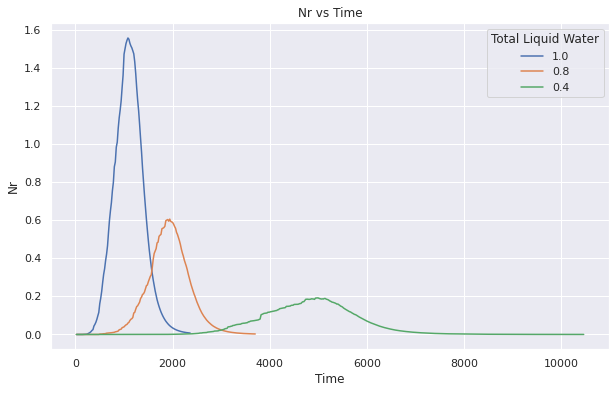

In [129]:

fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["time"].iloc[0:118]),(df["Nr"].iloc[0:118])/100000,label=df['lwc0'].iloc[1]*1000)
#plt.plot((df["time"].iloc[0:118]),(df["Nc"].iloc[0:118])/100000000)
#plt.plot(df["time"].iloc[0:118],df["tau"].iloc[0:118],color="black")

plt.plot((df["time"].iloc[119:304]),(df["Nr"].iloc[119:304])/100000,label=df['lwc0'].iloc[119]*1000)
plt.plot((df["time"].iloc[454:977]),(df["Nr"].iloc[454:977])/100000,label=df['lwc0'].iloc[454]*1000)
plt.xlabel('Time')
plt.ylabel('Nr')
plt.legend(title="Total Liquid Water")
plt.title("Nr vs Time")

Text(0.5, 1.0, 'Nr vs Tau')

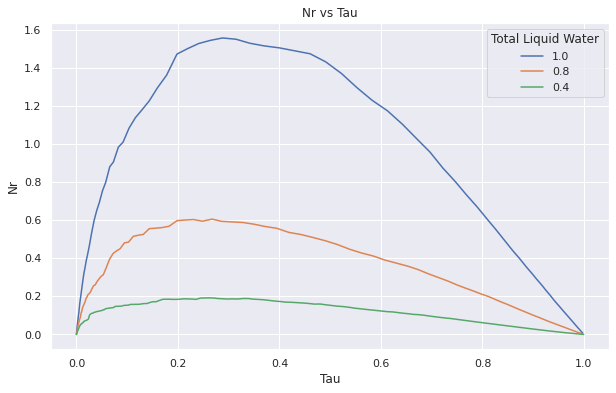

In [130]:

fig_size=[10,6]
fig= plt.figure()
fig.set_size_inches(fig_size)
plt.plot((df["tau"].iloc[0:118]),(df["Nr"].iloc[0:118])/100000,label=df['lwc0'].iloc[1]*1000)
#plt.plot((df["time"].iloc[0:118]),(df["Nc"].iloc[0:118])/100000000)
#plt.plot(df["time"].iloc[0:118],df["tau"].iloc[0:118],color="black")
plt.plot((df["tau"].iloc[119:304]),(df["Nr"].iloc[119:304])/100000,label=df['lwc0'].iloc[119]*1000)
plt.plot((df["tau"].iloc[454:977]),(df["Nr"].iloc[454:977])/100000,label=df['lwc0'].iloc[454]*1000)
plt.xlabel('Tau')
plt.ylabel('Nr')
plt.legend(title="Total Liquid Water")
plt.title("Nr vs Tau")

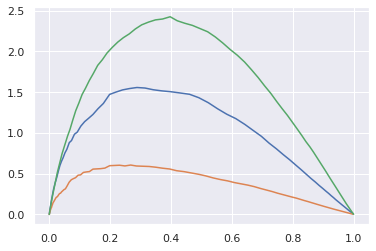

In [114]:
plt.plot((df["tau"].iloc[0:118]),(df["Nr"].iloc[0:118])/100000)
#plt.plot((df["tau"].iloc[0:118]),(df["Nc"].iloc[0:118])/100000000)
#plt.plot(df["time"].iloc[0:118],df["tau"].iloc[0:118],color="black")
plt.plot((df["tau"].iloc[119:304]),(df["Nr"].iloc[119:304])/100000)
plt.plot((df["tau"].iloc[305:453]),(df["Nr"].iloc[305:453])/100000)

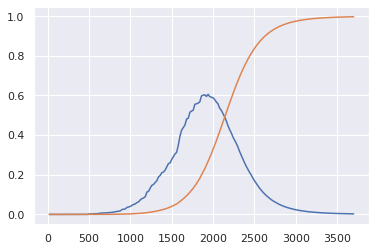

In [90]:
#plt.plot((df["tau"].iloc[0:110]),(df["Nr"].iloc[0:110])/100000000)
plt.plot((df["time"].iloc[119:304]),(df["Nr"].iloc[119:304])/100000)
plt.plot((df["time"].iloc[119:304]),(df["tau"].iloc[119:304]))

In [94]:
df["tau"].iloc[300:306]

300    0.996747
301    0.996927
302    0.997096
303    0.997256
304    0.997406
305    0.000003
Name: tau, dtype: float64

In [96]:
df["tau"].iloc[115:120]

115    0.997178
116    0.997399
117    0.997601
118    0.997785
119    0.000000
Name: tau, dtype: float64